In [8]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess
import cv2
import json
import requests
from tqdm import tqdm

from tensorflow.keras.layers import *

# Build and Deploy a CNN Classifier

## Load Dataset

In [3]:
data = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\nTrain_images.shape: {}, of {}'.format(x_train.shape, x_train.dtype))
print('Test_images.shape: {}, of {}'.format(x_test.shape, x_test.dtype))


Train_images.shape: (60000, 28, 28), of uint8
Test_images.shape: (10000, 28, 28), of uint8


## CNN Basics
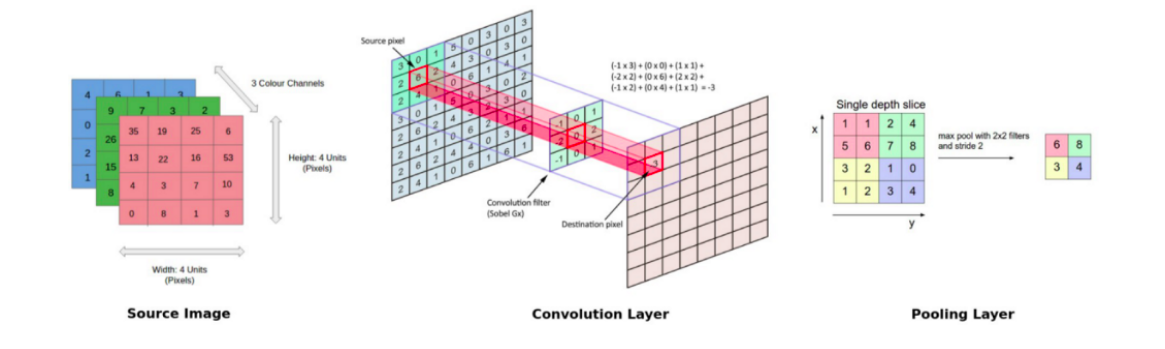

The key operations in a CNN model are depicted in the figure above. Any image can be represented as a tensor of pixel values. The convolution layers help in extracting features from this image (forms feature maps). Shallower layers (closer to the input data) in the network learn very generic features like edges, corners and so on. Deeper layers in the network (closer to the output layer) learn very specific features pertaining to the input image. The following graphic helps summarize the key aspects of any CNN model.

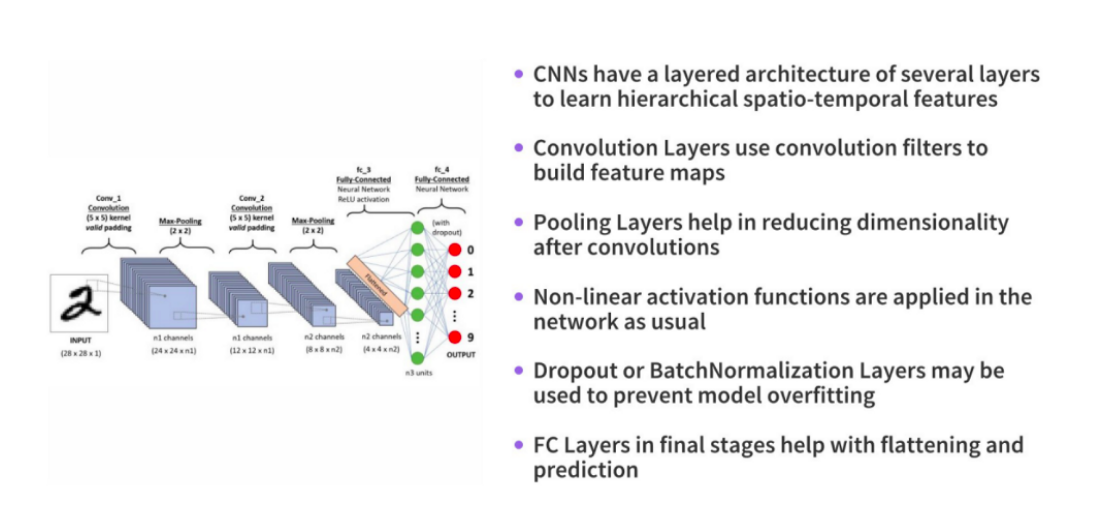

In [5]:
# Train a 2 layer CNN Classifier
x_train_gr = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test_gr = x_test.reshape(x_test.shape[0], 28, 28, 1)

print('\nTrain_images.shape: {}, of {}'.format(x_train_gr.shape, x_train_gr.dtype))
print('Test_images.shape: {}, of {}'.format(x_test_gr.shape, x_test_gr.dtype))


Train_images.shape: (60000, 28, 28, 1), of uint8
Test_images.shape: (10000, 28, 28, 1), of uint8


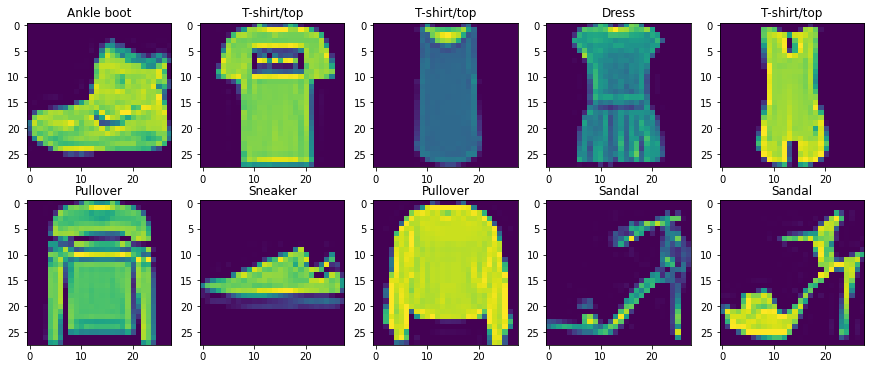

In [6]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
c = 0
for i in range(10):
    idx = i // 5
    idy = i % 5
    ax[idx, idy].imshow(x_train_gr[i].reshape(28, 28))
    ax[idx, idy].set_title(class_names[y_train[i]])

In [9]:
# Model
INPUT_SHAPE = (28, 28, 1)

model = tf.keras.Sequential([
    Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    # Set 2
    Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), 
                                activation='relu', padding='valid', input_shape=INPUT_SHAPE),
    MaxPooling2D(pool_size=(2, 2)),
    # Flatten
    Flatten(),
    
    # Add Dense layers with Dropout
    Dense(256, activation='relu'),
    Dropout(rate=0.3),
    Dense(256, activation='relu'),
    Dropout(rate=0.3),
    
    # Output
    Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               205056    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0

In [21]:
#Train
EPOCHS = 100
x_train = x_train_gr / 255.0
# EarlyStopping is used to stop training if no improvement is there during training (Prevents OverFitting)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

# Hit and trial mehtod has been done on batch_size and then the difference was visualized
history = model.fit(x_train, y_train, batch_size=32, callbacks=[callback], validation_split=0.1, epochs=EPOCHS, verbose=1)

Epoch 1/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1802 - accuracy: 0.9319 - val_loss: 0.2569 - val_accuracy: 0.9062
Epoch 2/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1726 - accuracy: 0.9347 - val_loss: 0.2706 - val_accuracy: 0.9107
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.1628 - accuracy: 0.9385 - val_loss: 0.2688 - val_accuracy: 0.9103
Epoch 00003: early stopping


<AxesSubplot:>

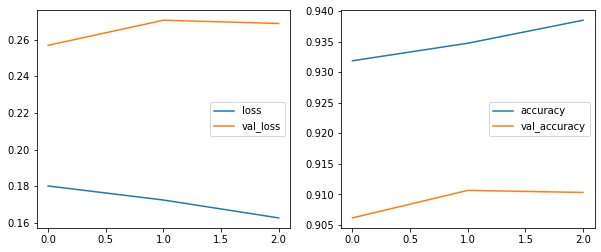

In [22]:
# Plot
import pandas as pd
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(kind='line', ax=ax[0])
history_df[['accuracy', 'val_accuracy']].plot(kind='line', ax=ax[1])

In [23]:
# Eval on test data
x_test = x_test_gr / 255.0
pred = model.predict(x_test)
pred[:5]

array([[1.3541536e-13, 5.1201566e-15, 3.0668278e-12, 5.5022024e-13,
        7.6404643e-13, 7.2424967e-07, 2.8351948e-12, 6.3800866e-07,
        5.4965350e-14, 9.9999869e-01],
       [1.1669876e-07, 3.5839882e-14, 9.9960130e-01, 3.1284364e-11,
        7.8533212e-06, 2.3943460e-14, 3.9073819e-04, 2.9612928e-16,
        1.3811816e-10, 2.6529686e-15],
       [6.1244609e-14, 1.0000000e+00, 1.1239014e-15, 4.9126085e-14,
        6.4949655e-18, 3.2606797e-20, 2.7152037e-15, 5.8495369e-20,
        3.1622726e-15, 6.6861423e-20],
       [7.8290895e-11, 1.0000000e+00, 1.1962016e-12, 6.4799455e-10,
        6.7236815e-15, 4.2402956e-16, 7.3870519e-12, 1.7756208e-15,
        2.4537664e-13, 2.1818180e-16],
       [1.4558506e-01, 3.4101063e-08, 1.4725025e-03, 1.7246832e-05,
        2.4578389e-04, 9.2467445e-08, 8.5267889e-01, 1.4337415e-10,
        4.4196878e-07, 9.0633739e-10]], dtype=float32)

In [24]:
pred_label = np.argmax(pred, axis=1)
pred_label[:5]

array([9, 2, 1, 1, 6], dtype=int64)

In [25]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, pred_label, target_names=class_names))
pd.DataFrame(confusion_matrix(y_test, pred_label), index=class_names, columns=class_names)

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.85      0.86      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.82      0.89      0.85      1000
       Dress       0.92      0.90      0.91      1000
        Coat       0.81      0.86      0.84      1000
      Sandal       0.95      0.99      0.97      1000
       Shirt       0.77      0.68      0.72      1000
     Sneaker       0.96      0.94      0.95      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.97      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,853,0,23,17,4,3,97,0,3,0
Trouser,3,978,1,12,2,0,2,0,2,0
Pullover,14,0,891,9,42,0,44,0,0,0
Dress,13,5,7,897,54,0,21,0,2,1
Coat,0,0,85,11,865,1,36,0,2,0
Sandal,0,0,0,0,0,992,0,5,0,3
Shirt,109,1,75,21,97,0,682,0,15,0
Sneaker,0,0,0,0,0,38,0,938,0,24
Bag,3,0,4,5,5,7,2,3,971,0
Ankle boot,0,0,0,0,0,8,1,34,0,957


In [26]:
print(y_test[:100])

[9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8 3 3 8 0 7
 5 7 9 6 1 3 7 6 7 2 1 2 2 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 2 3 9 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2]


In [27]:
y_test_idxs = [0, 23, 28]
y_test[y_test_idxs]

array([9, 9, 9], dtype=uint8)

In [28]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

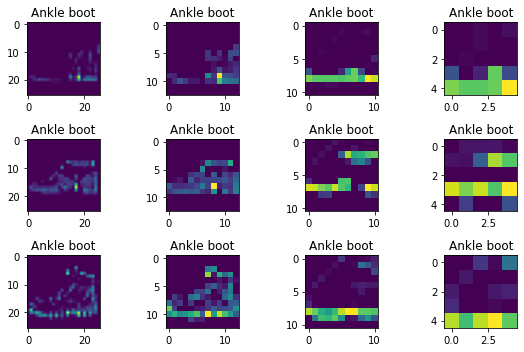

In [30]:
f, axarr = plt.subplots(3,4, figsize=(8, 5))

FIRST_IMAGE=0
SECOND_IMAGE=23
THIRD_IMAGE=28
CONVOLUTION_NUMBER = 13

for x in range(4):
    f1 = activation_model(x_test[0].reshape(1, 28, 28, 1))[x]
    axarr[0,x].imshow(f1[0, : , :, CONVOLUTION_NUMBER])
    axarr[0,x].grid(False)
    axarr[0,x].set_title(class_names[y_test[FIRST_IMAGE]])
    f2 = activation_model.predict(x_test[SECOND_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[1,x].imshow(f2[0, : , :, CONVOLUTION_NUMBER])
    axarr[1,x].grid(False)
    axarr[1,x].set_title(class_names[y_test[SECOND_IMAGE]])
    f3 = activation_model.predict(x_test[THIRD_IMAGE].reshape(1, 28, 28, 1))[x]
    axarr[2,x].imshow(f3[0, : , :, CONVOLUTION_NUMBER])
    axarr[2,x].grid(False)
    axarr[2,x].set_title(class_names[y_test[THIRD_IMAGE]])
plt.tight_layout()

## Fine Tune a Pretrained VGG-19 CNN Model
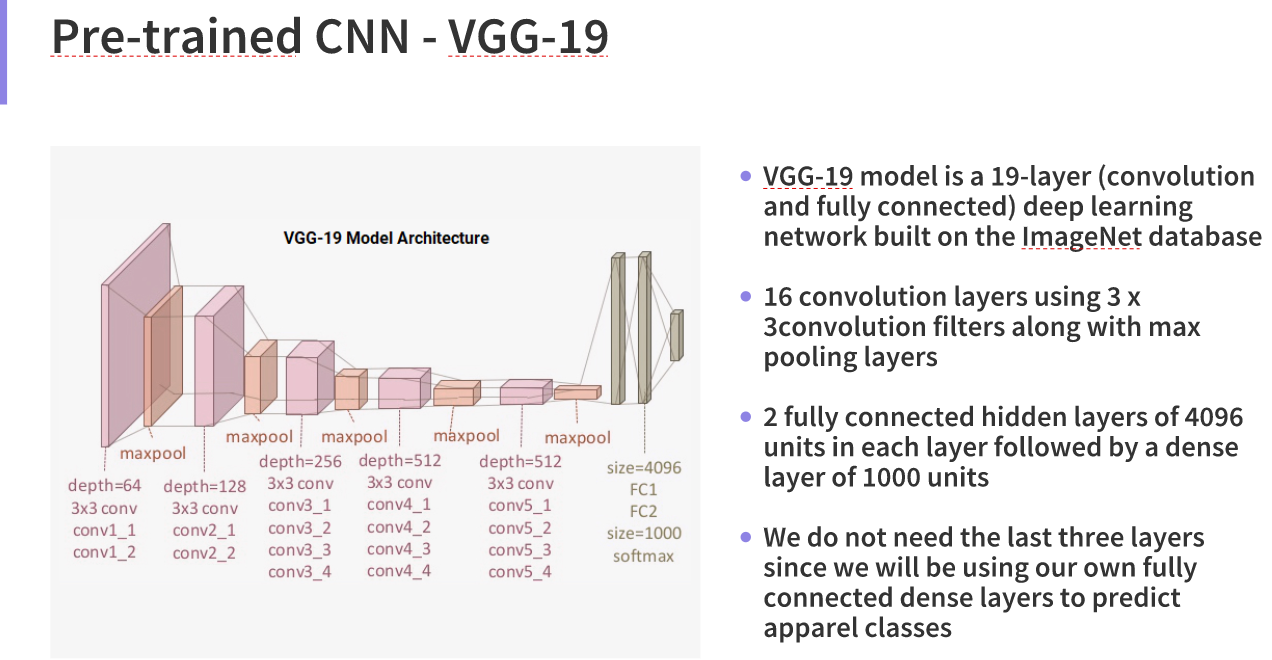

Using Transfer Learning
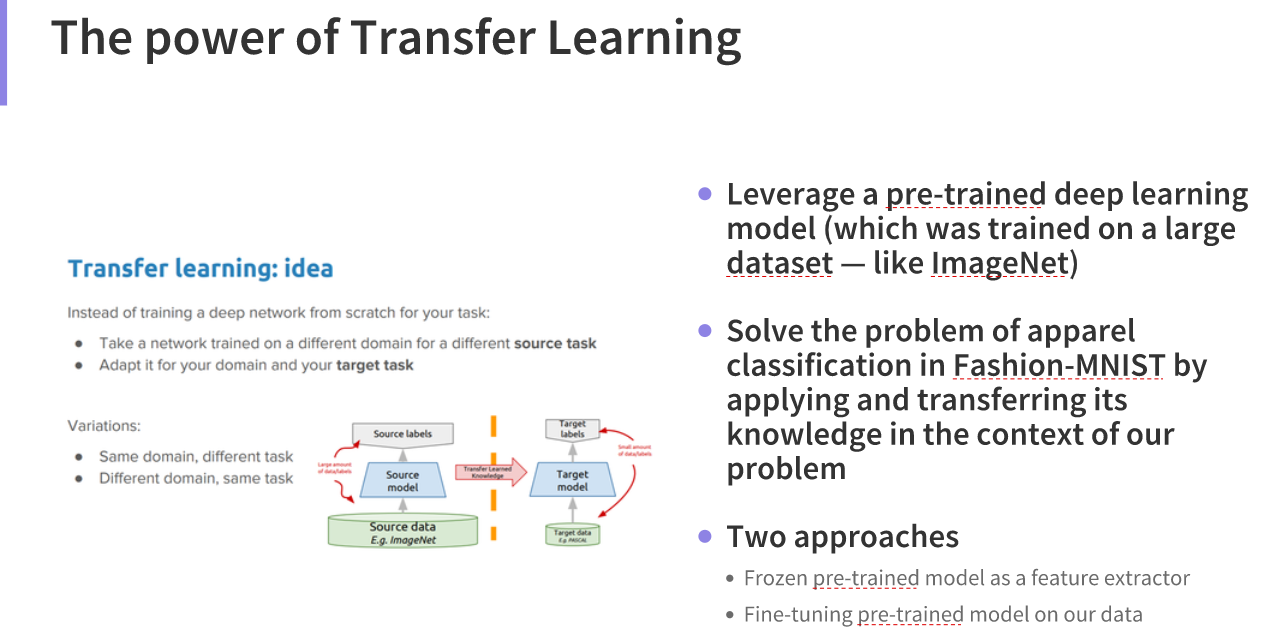

In [31]:
x_train_3ch = np.stack([x_train]*3, axis=-1)
x_test_3ch = np.stack([x_test]*3, axis=-1)

print('\nTrain_images.shape: {}, of {}'.format(x_train_3ch.shape, x_train_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(x_test_3ch.shape, x_test_3ch.dtype))


Train_images.shape: (60000, 28, 28, 1, 3), of float64
Test_images.shape: (10000, 28, 28, 1, 3), of float64


In [34]:
# Resize for Image Modelling 
def resize(img, img_size_dims):
    img = cv2.resize(img, dsize=img_size_dims, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

In [35]:
IMG_DIMS = (32, 32)

x_train_3ch = np.array([resize(img, img_size_dims=IMG_DIMS) for img in x_train_3ch])
x_test_3ch = np.array([resize(img, img_size_dims=IMG_DIMS) for img in x_test_3ch])

print('\nTrain_images.shape: {}, of {}'.format(x_train_3ch.shape, x_train_3ch.dtype))
print('Test_images.shape: {}, of {}'.format(x_test_3ch.shape, x_test_3ch.dtype))

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\resize.cpp:3688: error: (-215:Assertion failed) !dsize.empty() in function 'cv::hal::resize'
